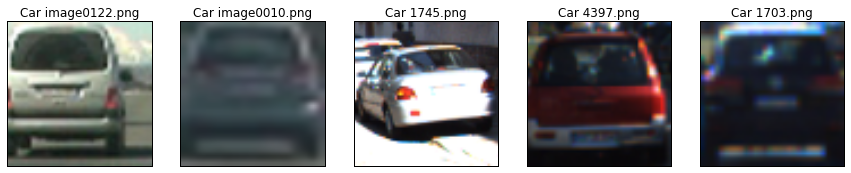

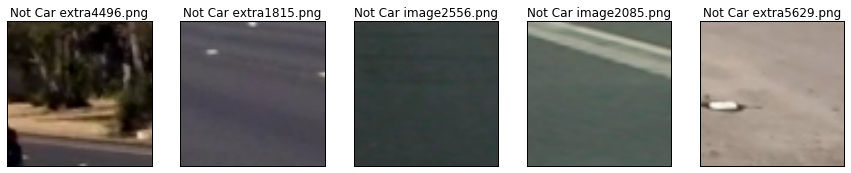

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

car_images = glob.glob('./Training/vehicles/*/*.png')
notcar_images = glob.glob('./Training/non-vehicles/*/*.png')

class ImageInfo:
    def __init__(self, img, title=None, cmap=None):
        self.img = img
        self.title = title
        self.cmap = cmap

def get_random_examples(img_files, pfx='', num_examples=5):
    examples = []
    for i in np.random.randint(0, high=len(img_files), size=num_examples):
        image = mpimg.imread(img_files[i])
        title = pfx + ' ' + img_files[i].split('/')[-1]
        examples.append(ImageInfo(image, title))
    return examples

def plot_images(img_list, size=(15,5), ncols=5):
    nrows=(len(img_list) + ncols - 1)//ncols
    plt.figure(figsize=size)
    pltnum = 1
    for imginfo in img_list:
        plt.subplot(nrows, ncols, pltnum)
        plt.imshow(imginfo.img, cmap=imginfo.cmap)
        if imginfo.title is not None:
            plt.title(imginfo.title, fontdict={'fontsize':12})
        plt.xticks([])
        plt.yticks([])
        pltnum += 1

car_examples = get_random_examples(car_images, pfx='Car')
plot_images(car_examples)

notcar_examples = get_random_examples(notcar_images, pfx='Not Car')
plot_images(notcar_examples)

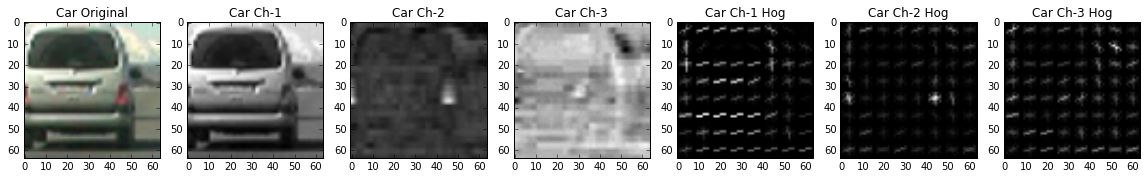

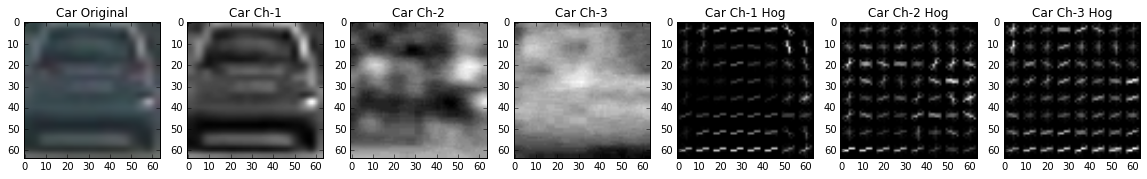

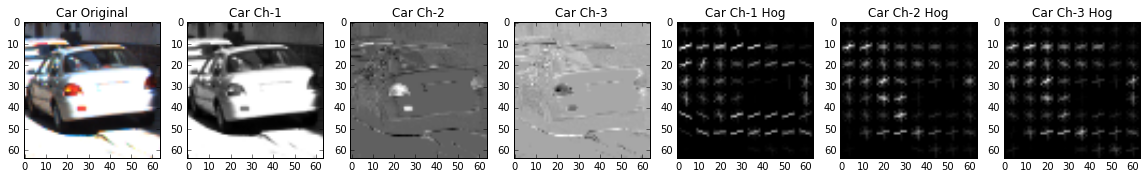

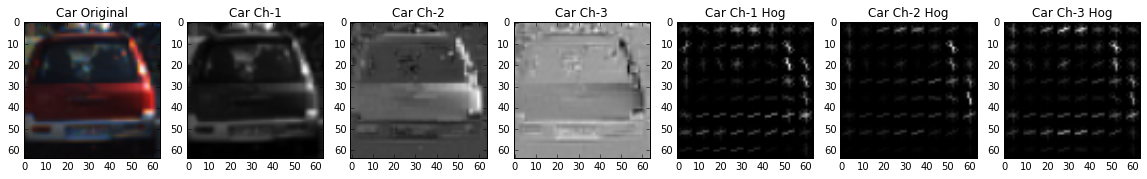

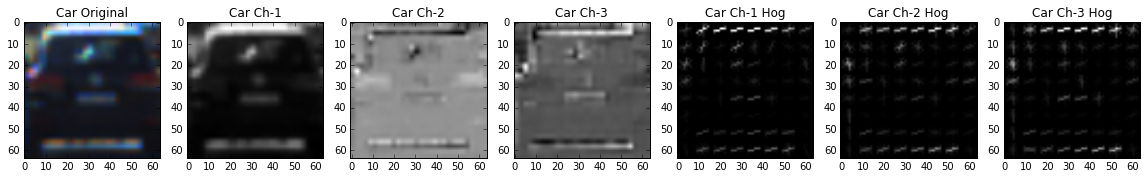

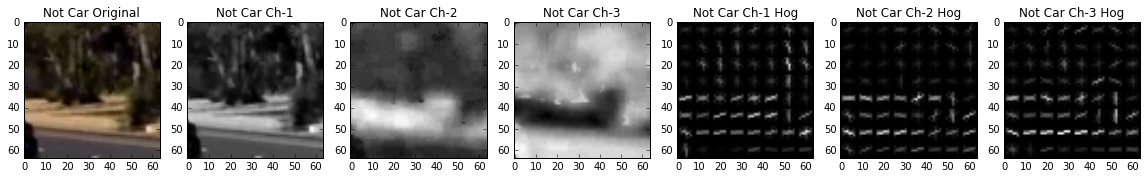

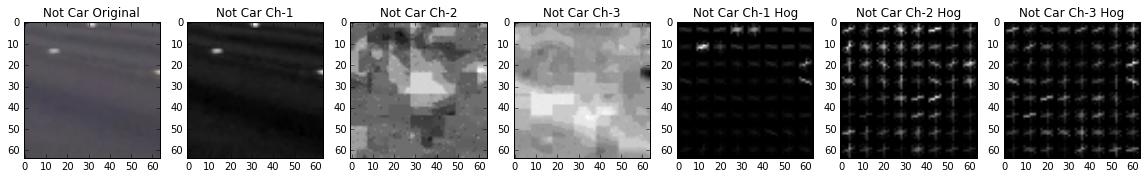

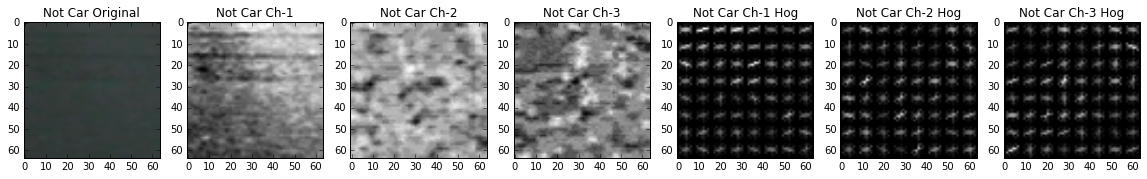

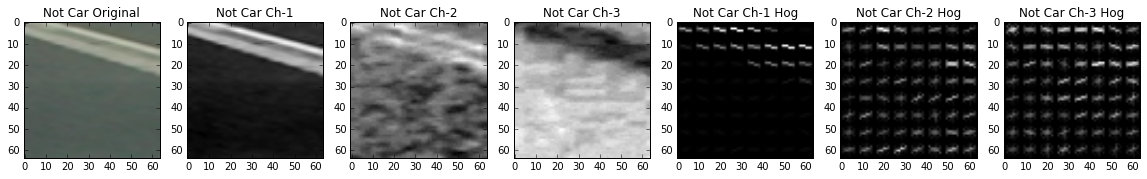

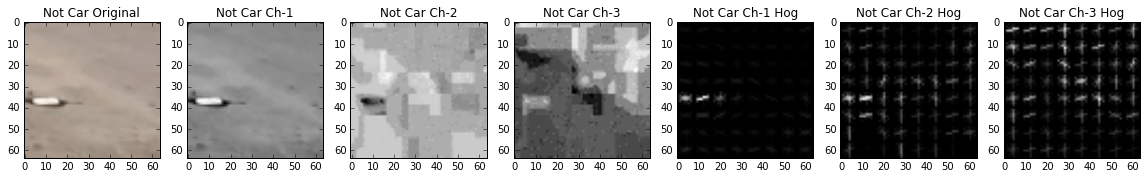

In [2]:
import cv2
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), visualise=vis,
                                  feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), visualise=vis,
                       feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def cvt_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        if color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if color_space == 'Lab':
            return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        if color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return img

def test_hog_features(img, prefix, color_space='RGB'):
    trans_image = cvt_color(img, color_space)
    ch1_img = trans_image[:,:,0]
    ch2_img = trans_image[:,:,1]
    ch3_img = trans_image[:,:,2]
    _, ch1_hog = get_hog_features(ch1_img, orient=11, pix_per_cell=8, cell_per_block=2,
                                  vis=True, feature_vec=False)
    _, ch2_hog = get_hog_features(ch2_img, orient=11, pix_per_cell=8, cell_per_block=2,
                                  vis=True, feature_vec=False)
    _, ch3_hog = get_hog_features(ch3_img, orient=11, pix_per_cell=8, cell_per_block=2,
                                  vis=True, feature_vec=False)
    
    fig, axs = plt.subplots(ncols=7, figsize=(20,5))
    axs[0].imshow(img)
    axs[0].set_title(prefix + ' Original')
    axs[1].imshow(ch1_img, cmap='gray')
    axs[1].set_title(prefix + ' Ch-1')
    axs[2].imshow(ch2_img, cmap='gray')
    axs[2].set_title(prefix + ' Ch-2')
    axs[3].imshow(ch3_img, cmap='gray')
    axs[3].set_title(prefix + ' Ch-3')
    axs[4].imshow(ch1_hog, cmap='gray')
    axs[4].set_title(prefix + ' Ch-1 Hog')
    axs[5].imshow(ch2_hog, cmap='gray')
    axs[5].set_title(prefix + ' Ch-2 Hog')
    axs[6].imshow(ch3_hog, cmap='gray')
    axs[6].set_title(prefix + ' Ch-3 Hog')

color_space = 'YCrCb'
for i in range(len(car_examples)):
    test_hog_features(car_examples[i].img, 'Car', color_space)
    
for i in range(len(notcar_examples)):
    test_hog_features(notcar_examples[i].img, 'Not Car', color_space)

In [3]:
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

In [4]:
from tqdm import tqdm

def single_img_features(img, color_space='RGB', spatial_size=(32,32), hist_bins=32,
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    file_features = []
    img = cvt_color(img, color_space)
    
    if spatial_feature:
        file_features.append(bin_spatial(img, size=spatial_size))
    if hist_feature:
        file_features.append(color_hist(img, nbins=hist_bins))
    if hog_feature:
        features_hog = []
        if hog_channel == 'ALL':
            for channel in range(img.shape[2]):
                features_hog.append(get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block))
        else:
            features_hog.append(get_hog_features(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block))
        
        features_hog = np.ravel(features_hog)
        file_features.append(features_hog)

    return np.concatenate(file_features)

def extract_features(imgs, desc, color_space='RGB', spatial_size=(32,32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feature=True, hist_feature=True, hog_feature=True):
    features = []
    for im_file in tqdm(imgs, desc):
        img = mpimg.imread(im_file)
        single_features = single_img_features(img, color_space, spatial_size, hist_bins,
                                              orient, pix_per_cell, cell_per_block, hog_channel,
                                              spatial_feature, hist_feature, hog_feature)
        features.append(single_features)
    return features
    
# Parameters to extract features
color_space = 'YCrCb'
spatial_size=(32,32)
hist_bins=32
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features(car_images, 'Extracting car features', color_space, spatial_size, \
                                hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)

notcar_features = extract_features(notcar_images, 'Extracting not car features', color_space, spatial_size, \
                                   hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)

Extracting not car features: 100%|██████████| 8968/8968 [01:04<00:00, 139.39it/s]


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [9]:
from sklearn.svm import LinearSVC

svc = LinearSVC(verbose=1)
svc.fit(X_train, y_train)
print('Test Accuracy = ', round(svc.score(X_test, y_test), 4))

[LibLinear]Test Accuracy =  0.9876


/home/rajat/miniconda3/envs/carnd-term1/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


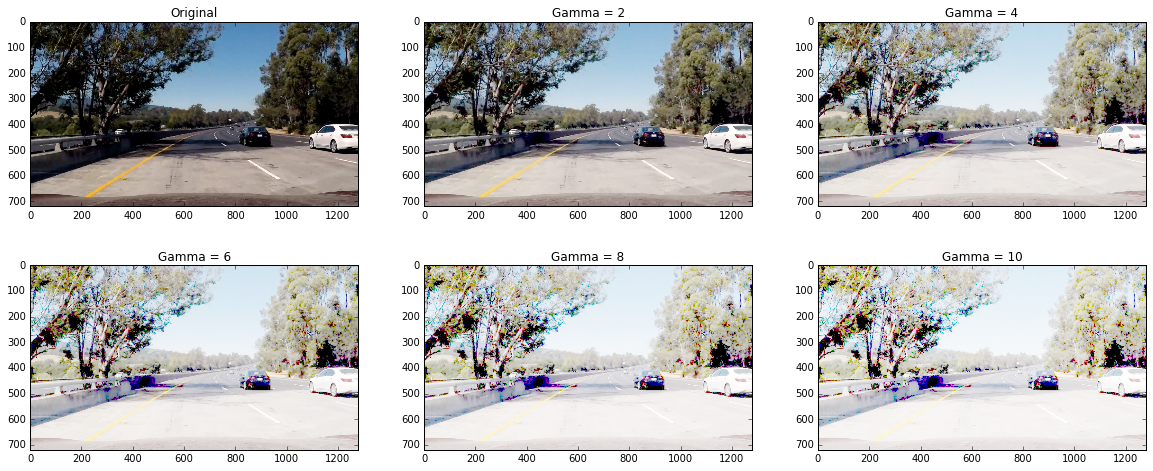

In [10]:
def adjust_gamma(img, gamma=1.0):
    table = np.array([((i/255.0)**(1/gamma))*255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(img, table)

test_img = mpimg.imread('./test_images/test5.jpg')
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axs[0][0].imshow(test_img)
axs[0][0].set_title('Original')
axs[0][1].imshow(adjust_gamma(test_img, gamma=2.0))
axs[0][1].set_title('Gamma = 2')
axs[0][2].imshow(adjust_gamma(test_img, gamma=4.0))
axs[0][2].set_title('Gamma = 4')
axs[1][0].imshow(adjust_gamma(test_img, gamma=6.0))
axs[1][0].set_title('Gamma = 6')
axs[1][1].imshow(adjust_gamma(test_img, gamma=8.0))
axs[1][1].set_title('Gamma = 8')
axs[1][2].imshow(adjust_gamma(test_img, gamma=10.0))
axs[1][2].set_title('Gamma = 10')

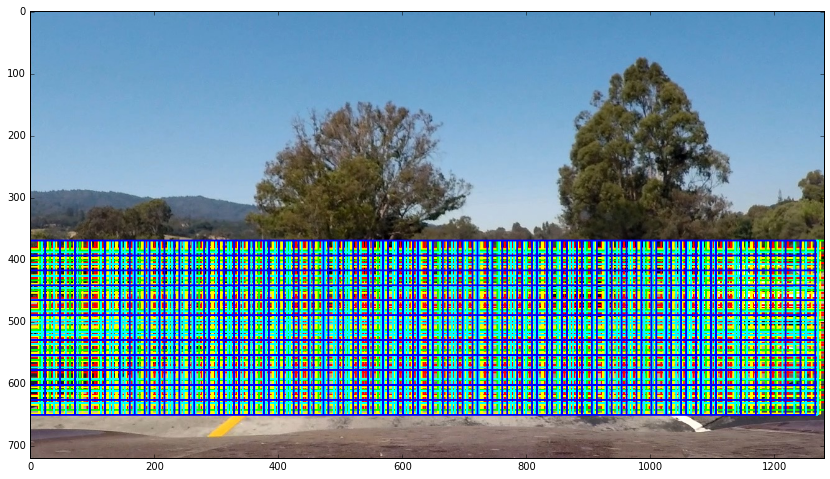

In [11]:
def draw_boxes(img, bboxes, color=(255, 255, 0), thick=2):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    img = img.astype(np.float32)/255
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    window_list = []
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    x_pix_per_step = int(xy_window[1]*(1 - xy_overlap[1]))
    y_pix_per_step = int(xy_window[0]*(1 - xy_overlap[0]))
    x_last_no_overlap = int(xy_window[1]*xy_overlap[1])
    y_last_no_overlap = int(xy_window[0]*xy_overlap[0])
    nx_windows = (x_span - x_last_no_overlap)//x_pix_per_step
    ny_windows = (y_span - y_last_no_overlap)//y_pix_per_step

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*x_pix_per_step + x_start_stop[0]
            starty = ys*y_pix_per_step + y_start_stop[0]
            endx = startx + xy_window[1]
            endy = starty + xy_window[0]
            window = ((startx, starty), (endx, endy))
            window_list.append(window)
    return window_list

def create_multiscale_windows(img, display=False):
    window_list = []
  
    y_start_stop = [370, 650]
    overlap = 0.85
    slide_window_sizes = (80, 96, 112, 128, 160)
    color_list = ((255, 0, 0), (255, 255, 0), (0, 255, 0), (0, 255, 255), (0, 0, 255))
    win_img = img
    for window_size, color in zip(slide_window_sizes, color_list):
        windows = slide_window(img, y_start_stop=y_start_stop, xy_window=(window_size, window_size),
                               xy_overlap=(overlap, overlap))
        if display:
            win_img = draw_boxes(win_img, windows, color=color)
        window_list += windows
    
    if display:
        plt.figure(figsize=(15,8))
        plt.imshow(win_img)
            
    return window_list

test_img = mpimg.imread('./test_images/test1.jpg')
windows = create_multiscale_windows(test_img, display=True)

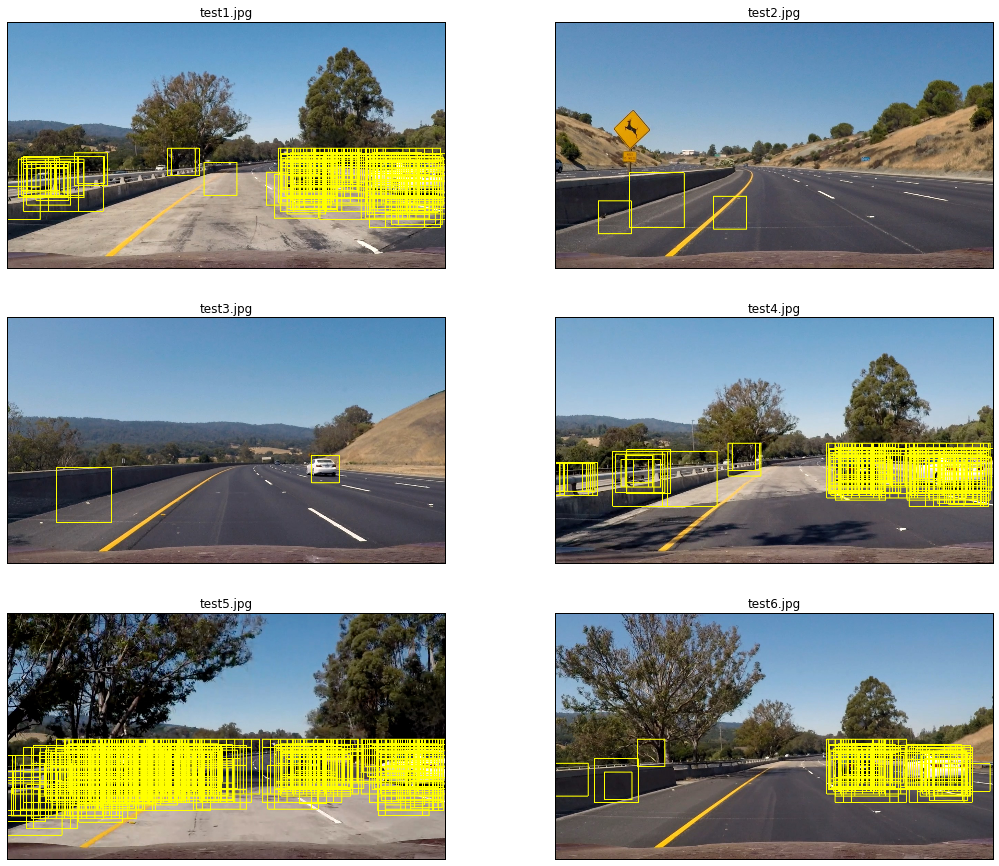

In [12]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32, orient=9,
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feature=True, hist_feature=True, hog_feature=True):
    
    img = img.astype(np.float32)/255
    windows_match = []
    for window in windows:
        window_crop = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(window_crop, color_space, spatial_size, hist_bins,
                                       orient, pix_per_cell, cell_per_block, hog_channel,
                                       spatial_feature, hist_feature, hog_feature)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            windows_match.append(window)
    
    return windows_match

detected_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    windows = create_multiscale_windows(test_img)
    gamma_img = adjust_gamma(test_img, gamma=5.0)
    hot_windows = search_windows(gamma_img, windows, svc, X_scaler, color_space, spatial_size, \
                                 hist_bins, orient, pix_per_cell, cell_per_block, hog_channel)
    win_img = draw_boxes(test_img, hot_windows)
    title = test_file.split('/')[-1]
    detected_images.append(ImageInfo(win_img, title))
    
plot_images(detected_images, size=(18, 15), ncols=2)

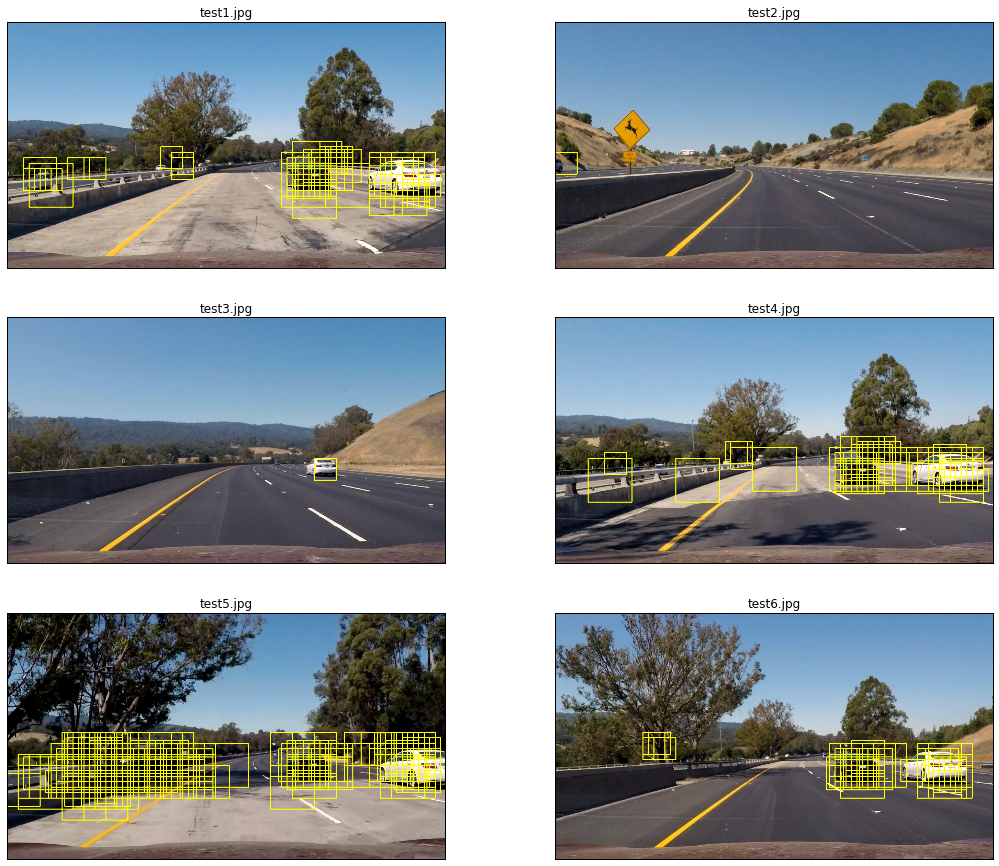

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, ystart, xstop, ystop, scale, svc, X_scaler, color_space,
              orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins):
    
    windows_match = []
    img = adjust_gamma(img, gamma=5)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cvt_color(img_tosearch, color_space)
    
    if scale != 1.0:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows_match.append(((xbox_left+xstart, ytop_draw+ystart),
                                      (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))) 
                
    return windows_match

def find_cars_multi_scale(img, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block,
                          hog_channel, spatial_size, hist_bins):
    ystart = 350
    ystop = 650
    xstart = 0
    xstop = img.shape[1]

    hot_windows = []
    for scale in [1, 1.5, 2]:
        hot_windows += find_cars(img, xstart, ystart, xstop, ystop, scale, svc, X_scaler, color_space,
                                 orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
    return hot_windows

detected_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    hot_windows = find_cars_multi_scale(test_img, svc, X_scaler, color_space, orient,
                                        pix_per_cell, cell_per_block, hog_channel,
                                        spatial_size, hist_bins)
    out_img = draw_boxes(test_img, hot_windows)
    title = test_file.split('/')[-1]
    detected_images.append(ImageInfo(out_img, title))
    
plot_images(detected_images, size=(18, 15), ncols=2)


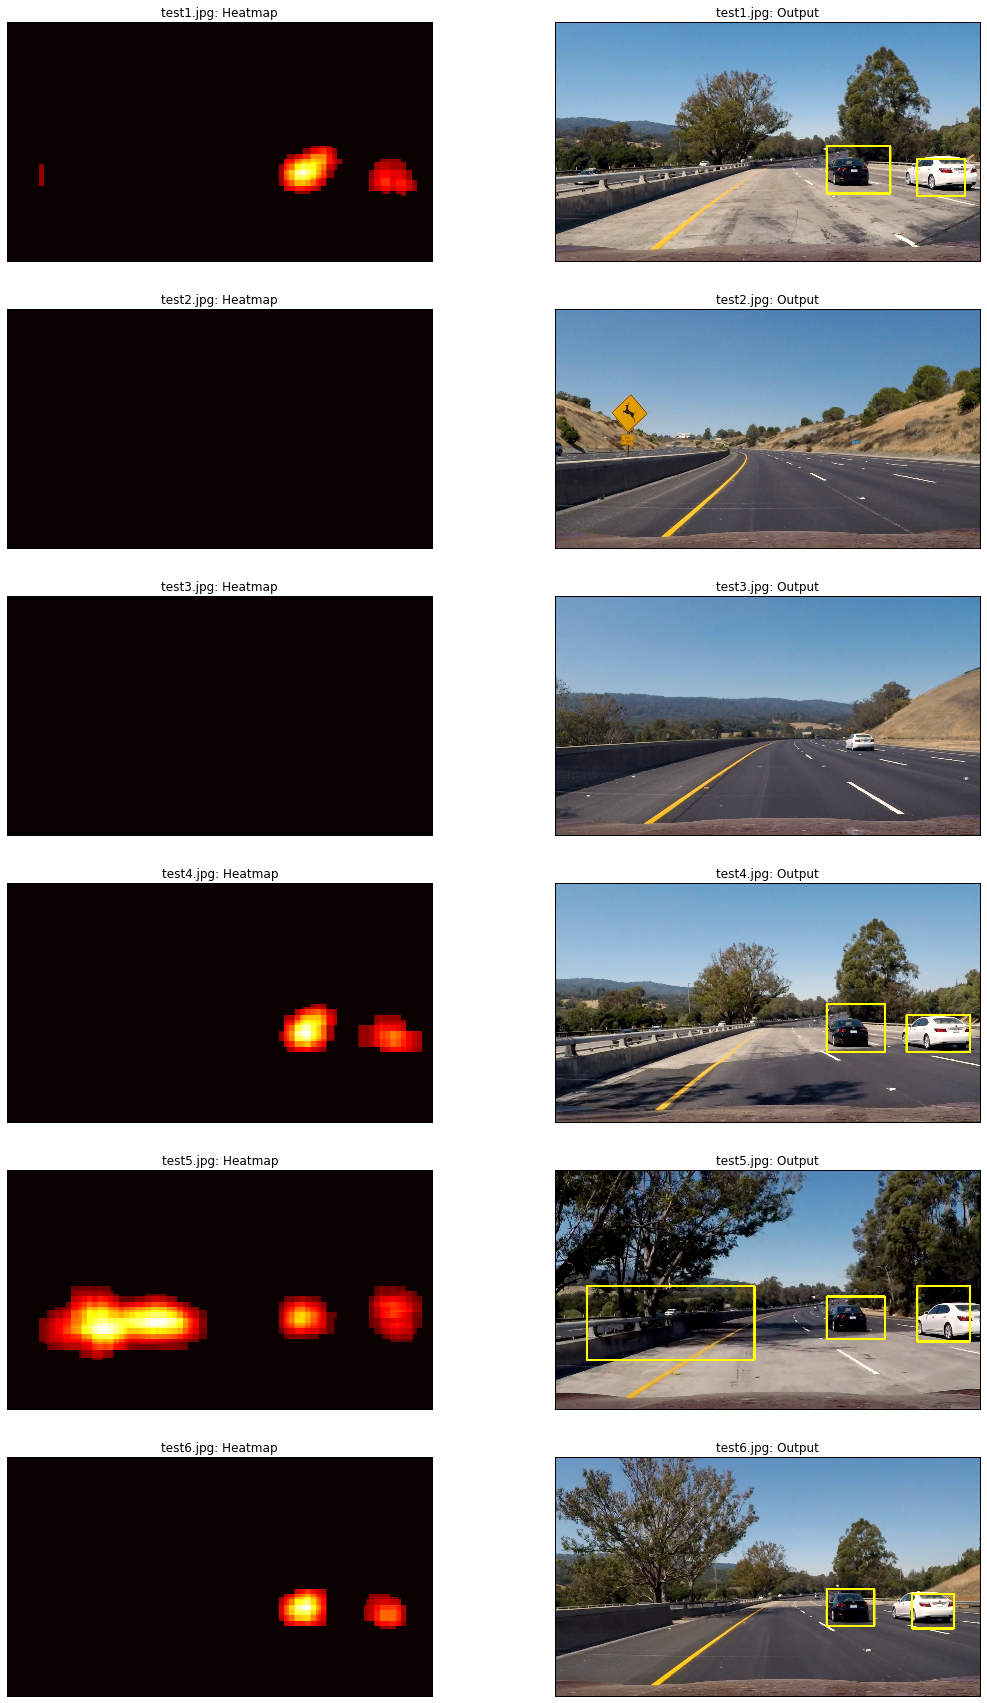

In [14]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, hot_windows):
    for window in hot_windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold=5):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def box_looks_good(bbox):
    height = bbox[1][1] - bbox[0][1]
    width = bbox[1][0] - bbox[0][0]
    area = height * width
    return (area >= 2500) and (height >= 50) and (width >= 50)

def draw_labeled_bboxes(img, heatmap):
    labels = label(heatmap)
    out_img = np.copy(img)
    for label_val in range(1, labels[1]+1):
        nonzero = (labels[0] == label_val).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if box_looks_good(bbox):
            cv2.rectangle(out_img, bbox[0], bbox[1], (255,255,0), 6)
    return out_img
    
display_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    hot_windows = find_cars_multi_scale(test_img, svc, X_scaler, color_space, orient,
                                        pix_per_cell, cell_per_block, hog_channel,
                                        spatial_size, hist_bins)
    heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap)
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    title = test_file.split('/')[-1]
    display_images.append(ImageInfo(heatmap, title=title + ': Heatmap', cmap='hot'))
    
    output_image = draw_labeled_bboxes(test_img, heatmap)
    display_images.append(ImageInfo(output_image, title=title + ': Output'))
    
plot_images(display_images, size=(18, 30), ncols=2)

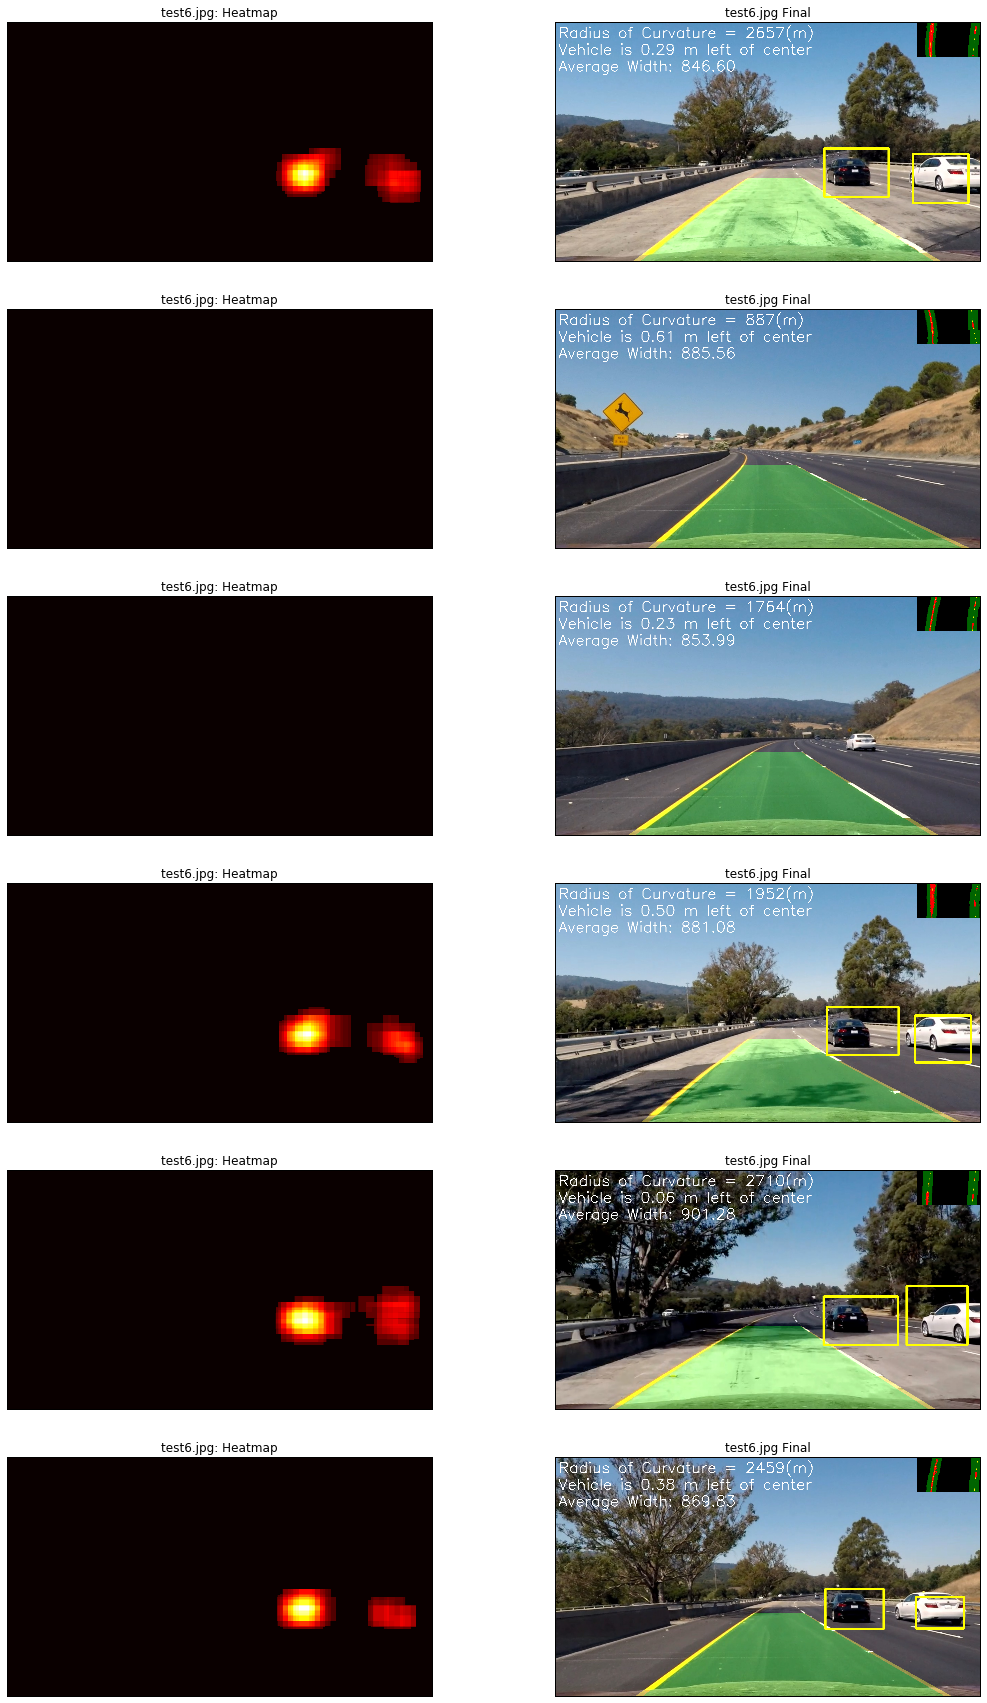

In [15]:
from AdvanceLaneFinding import LaneDetector

def find_cars_with_left_wall(img, left_fit, svc, X_scaler, color_space, orient,
                             pix_per_cell, cell_per_block, hog_channel,
                             spatial_size, hist_bins):
    hot_windows = []
    ystop = 650
    xstop = img.shape[1]
    for ystart in np.arange(350, 600, 50):
        xstart = np.int32(left_fit[0]*ystart**2 + left_fit[1]*ystart + left_fit[2])
        for scale in [1.0, 1.5, 2.0]:
            hot_windows += find_cars(img, xstart, ystart, xstop, ystop, scale,
                                     svc, X_scaler, color_space, orient,
                                     pix_per_cell, cell_per_block,
                                     hog_channel, spatial_size, hist_bins)
    return hot_windows

display_images = []
for test_file in sorted(glob.glob('./test_images/test*.jpg')):
    test_img = mpimg.imread(test_file)
    
    # detect lane markings
    lane_detector = LaneDetector(debug=True)
    lane_img = lane_detector.process_frame(test_img)
    undist_img = lane_detector.undist_img
    
    # Apply left wall using detected left lane markings
    left_fit = lane_detector.get_unwarped_line_fit(margin=50)
                             
    # Find candidate windows with car images
    hot_windows = find_cars_with_left_wall(undist_img, left_fit, svc, X_scaler, color_space,
                                           orient, pix_per_cell, cell_per_block, hog_channel,
                                           spatial_size, hist_bins)
    
    # Apply heatmap threshold
    heatmap = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap)
    heatmap = np.clip(heatmap, 0, 255)
    display_images.append(ImageInfo(heatmap, title=title + ': Heatmap', cmap='hot'))
    
    # Create output image with bounding boxes and lane markings
    out_img = draw_labeled_bboxes(lane_img, heatmap)
    display_images.append(ImageInfo(out_img, title + ' Final'))
    
plot_images(display_images, size=(18, 30), ncols=2)

In [22]:
from collections import deque

class CarsLaneDetector:
    def __init__(self, heat_threshold=10, n_frames=20):
        self.heat_threshold = heat_threshold
        self.heatmaps = deque(maxlen=n_frames)
        self.lane_detector = LaneDetector(n_frames, debug=True)

    def process_frame(self, img):
        lane_image = self.lane_detector.process_frame(img)
        img = self.lane_detector.undist_img
        
        # Apply left wall using detected left lane markings
        left_fit = lane_detector.get_unwarped_line_fit(margin=50)
                             
        # Find candidate windows with car images
        hot_windows = find_cars_with_left_wall(img, left_fit, svc, X_scaler, color_space,
                                               orient, pix_per_cell, cell_per_block, hog_channel,
                                               spatial_size, hist_bins)
        
        # Caculate average heatmap of current frame along with previous frames
        # and select based on heatmap threshold
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat, hot_windows)
        self.heatmaps.append(heat)
        heat = sum(self.heatmaps)/len(self.heatmaps)
        heat = apply_threshold(heat, self.heat_threshold)
        heat = np.clip(heat, 0, 255).astype(np.uint8)
        
        # draw boxes on lane detected image for final output
        car_lane_image = draw_labeled_bboxes(lane_image,heat)
        color_heat = cv2.applyColorMap(heat*10, cv2.COLORMAP_HOT)
        color_heat = cv2.resize(color_heat, (0,0), fx=0.15, fy=0.15)
        car_lane_image[color_heat.shape[0]+10:2*color_heat.shape[0]+10,
                       car_lane_image.shape[1]-color_heat.shape[1]:] = color_heat 
        return car_lane_image

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_file="test_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
cars_lane_detect = CarsLaneDetector()
marked_clip = clip.fl_image(cars_lane_detect.process_frame)
%time marked_clip.write_videofile(output_video, audio=False, threads=4)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [01:58<00:03,  3.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 2min 10s, sys: 452 ms, total: 2min 10s
Wall time: 1min 59s


In [ ]:
video_file="project_video.mp4"
output_video = "output_images/" + video_file
clip = VideoFileClip("./" + video_file)
cars_lane_detect = CarsLaneDetector()
marked_clip = clip.fl_image(cars_lane_detect.process_frame).subclip(40,43)
%time marked_clip.write_videofile(output_video, audio=False, threads=4)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


 92%|█████████▏| 70/76 [03:48<00:19,  3.20s/it]